## 1. Chargement et Aperçu des Données

Nous commençons par charger le dataset et examiner ses premières lignes pour comprendre sa structure.

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Chargement du dataset (simulé)
df = pd.read_csv('spotify_songs.csv')

print("--- Premières lignes du dataset ---")
print(df.head())

print("\n--- Informations sur les colonnes (types et valeurs non nulles) ---")
print(df.info())

--- Premières lignes du dataset ---
                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   
1  0r7CVbZTWZgbTCYdfa2P31                    Memories - Dillon Francis Remix   
2  1z1Hg7Vb0AhHDiEmnDE79l                    All the Time - Don Diablo Remix   
3  75FpbthrwQmzHlBJLuGdC7                  Call You Mine - Keanu Silva Remix   
4  1e8PAfcKUYoKkxPhrHqw4x            Someone You Loved - Future Humans Remix   

       track_artist  track_popularity          track_album_id  \
0        Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   
1          Maroon 5                67  63rPSO264uRjW1X5E6cWv6   
2      Zara Larsson                70  1HoSmj2eLcsrR0vE9gThr4   
3  The Chainsmokers                60  1nqYsOef1yKKuGOVchbsk6   
4     Lewis Capaldi                69  7m7vv9wlQ4i0LFuJiE2zsQ   

                                    track_album_name track_album_release_date  \
0  I Don't 

## 2. Choix et Justification des Features pour le Modèle

L'objectif est de construire un espace vectoriel pour la recommandation. Nous devons inclure uniquement les colonnes qui representent au maximum un morceau, tout en écartant les informations qui n'influencent pas la similarité perçue par l'utilisateur.

A. Les Features Vectorielles Retenues (Incluses dans l'ACP)
Ces 12 colonnes numériques sont choisies car elles offrent la description la plus complète de l'ADN audio d'un morceau, essentiel pour calculer les distances de similarité.

tempo : Inclus. La vitesse est Cruciale. C'est un facteur déterminant du genre (rapide pour l'EDM, lent pour la ballade) et de l'énergie. L'inclure est indispensable.

energy : Inclus. Mesure l'intensité et l'activité (0 à 1). Essentiel. C'est un proxy direct de l'humeur et du style agressif ou calme du morceau.

valence : Inclus. Décrit la positivité musicale (joie vs. tristesse) (0 à 1). Essentiel. L'humeur est l'un des critères de recommandation les plus importants pour l'utilisateur final.

acousticness : Inclus. Probabilité que le morceau soit acoustique (0 à 1). Très Pertinent. Permet de séparer les productions modernes électroniques des sons organiques ou classiques.

loudness : Inclus. Niveau sonore général en décibels (dB). Très Pertinent. Une plus grande loudness est souvent associée à une production moderne et à une énergie élevée, influençant la perception.

danceability : Inclus. Mesure l'aptitude d'un morceau à être dansé (0 à 1). Très Pertinent. C'est un bon résumé de la régularité rythmique et de l'adéquation aux genres populaires.

instrumentalness : Inclus. Probabilité que le morceau soit purement instrumental (0 à 1). Très Pertinent. Un critère stylistique majeur : on ne recommande pas de la musique vocale à quelqu'un qui écoute des instrumentaux.

liveness : Inclus (avec prudence). Indique la probabilité que l'enregistrement ait été fait en public. Moyennement Pertinent. Ajoute une dimension de "texture" ou d'ambiance (live vs. studio).

speechiness : Inclus (avec prudence). Décrit la présence de mots parlés. Moyennement Pertinent. Utile pour distinguer les chansons classiques des morceaux centrés sur la parole (rap, poésie).

duration_ms : Inclus (avec prudence). Représente la durée du morceau. Faible Pertinence Stylistique. La durée seule ne définit pas le genre. Nous l'incluons dans l'ACP uniquement parce que sa suppression pourrait masquer une faible corrélation avec le style (ex: morceaux de rock courts vs. morceaux de jazz longs). Nécessite une Standardisation rigoureuse.

key : Inclus (avec prudence). La tonalité du morceau (0 à 11). Faible Pertinence. Caractéristique très technique. L'utilisateur moyen ne base pas sa similarité là-dessus, mais elle pourrait apporter une information pour la cohérence musicale.

mode : Inclus (avec prudence). Majeur (1) ou Mineur (0). Faible Pertinence. Similaire à key, son impact est probablement minime.

Conclusion de la sélection : Nous retenons les 12 colonnes numériques comme point de départ. L'ACP nous aidera ensuite à filtrer les colonnes à faible impact comme key ou mode en les absorbant dans des composantes peu significatives.

Pourquoi ces données ? Ces valeurs sont les seules à pouvoir être utilisées pour créer un point (un vecteur) dans notre espace de similarité. Par exemple, si deux morceaux ont des valeurs similaires pour energy et valence, ils seront mathématiquement proches, même s'ils sont joués par des artistes différents. L'ACP se fera uniquement sur ces données pour simplifier les calculs de distance.

In [5]:
feature_cols = [
    'danceability', 'energy', 'key', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness',
    'liveness', 'valence', 'tempo', 'duration_ms'
]

B. Les Features d'Information Exclues (Non Incluses dans l'ACP)
Ces colonnes sont totalement inutiles pour le calcul de similarité mathématique et ne doivent pas influencer l'ACP.

track_name, track_artist, track_album_name : Exclues. Informations d'affichage essentielles pour l'interface, mais sans valeur descriptive pour le modèle de similarité.

track_popularity : Exclue. C'est une mesure de l'intérêt global des utilisateurs, et non une caractéristique musicale. L'inclure fausserait l'ACP en donnant la priorité aux morceaux populaires, ce qui nuirait à l'objectif de découverte de l'application.

playlist_genre, playlist_subgenre : Exclues. Elles sont catégorielles (texte) et subjectives. Notre modèle a pour but de déduire la similarité de genre à partir des features numériques.

track_id et autres identifiants : Exclues. Métadonnées administratives sans aucune valeur descriptive pour le modèle.

Pourquoi sont-elles exclues de l'ACP ? Des données comme track_artist (texte), track_name (texte), ou track_popularity ne peuvent pas être utilisées dans un calcul de distance euclidienne. L'artiste, par exemple, n'est pas une mesure de style, mais d'identité. L'inclure fausserait le modèle.

⚠️ Warning : Exploitation Différée des Données Clés

Bien que non incluses dans l'ACP, des colonnes comme track_artist et track_popularity sont cruciales pour l'application !

track_artist : Nous l'utiliserons plus tard pour le profilage utilisateur. Si l'utilisateur aime un artiste, nous recommanderons d'autres morceaux de cet artiste (approche basée sur le contenu).

track_popularity : Nous l'utiliserons pour gérer le démarrage à froid (cold start) de l'application (mettre des morceaux mainstream en premier) et pour contrôler la proportion de nouvelles découvertes (faible popularité) dans les recommandations finales.

## 3. Préparation des Données : Standardisation 

3.1. Le Concept et la Justification
L'étape de Standardisation Z-Score est une phase de prétraitement des données obligatoire avant d'appliquer l'Analyse en Composantes Principales (ACP).

La raison fondamentale de cette standardisation réside dans l'obtention d'une uniformité de l'espace vectoriel. Nos douze features numériques sont hétérogènes. Par exemple, le loudness est mesuré en décibels, avec des valeurs généralement comprises entre -10 et 0, tandis que la duration_ms est en millisecondes, avec des valeurs qui peuvent atteindre plusieurs centaines de milliers.

Cette hétérogénéité des échelles pose un risque majeur de prévention du biais. Si nous n'effectuons pas cette opération, les variables avec la plus grande magnitude (principalement duration_ms et tempo) domineraient mathématiquement l'ACP. L'algorithme percevrait ces variables comme les plus importantes, non pas en raison de leur pertinence stylistique, mais simplement parce qu'elles génèrent la plus grande variance numérique.

La Solution Z-Score résout ce problème en utilisant le StandardScaler de scikit-learn. Cet outil transforme chaque colonne pour qu'elle ait une moyenne ($\mu$) égale à $0$ et un écart-type ($\sigma$) égal à $1$. Après cette transformation, toutes les features, qu'il s'agisse de l'énergie, de la valence, ou de la durée, contribuent équitablement à la variance totale du jeu de données.

In [6]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# 1. Préparation des données d'entrée
X = df[feature_cols].copy()
# -> Nous créons une copie du sous-ensemble des données (X) que nous voulons transformer.

# 2. Instanciation du StandardScaler
scaler = StandardScaler()
# -> Nous créons une instance de l'objet qui va effectuer la transformation.

# 3. Ajustement (fit) et Transformation (transform) des données
X_scaled = scaler.fit_transform(X)
# -> .fit(X) calcule la moyenne et l'écart-type pour chaque colonne de X.
# -> .transform(X) applique ensuite la formule Z-Score (X - mu) / sigma à chaque valeur.
# Le résultat X_scaled est un tableau NumPy (ndarray).

# 4. Conversion en DataFrame pour la lisibilité
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
# -> Nous reconvertissons le tableau NumPy en un DataFrame Pandas pour faciliter l'inspection et les étapes suivantes.

print("--- Statistiques Descriptives Après Standardisation (Z-Score) ---")
# On vérifie que la 'mean' est très proche de 0 et le 'std' est proche de 1.
print(X_scaled_df.describe().T)
# -> L'affichage de ces statistiques confirme visuellement que la standardisation a bien été effectuée.

--- Statistiques Descriptives Après Standardisation (Z-Score) ---
                    count          mean       std        min       25%  \
danceability      32833.0  1.662038e-16  1.000015  -4.513616 -0.633082   
energy            32833.0 -2.458431e-16  1.000015  -3.860786 -0.650163   
key               32833.0 -1.229215e-16  1.000015  -1.488113 -0.934342   
loudness          32833.0 -2.908566e-16  1.000015 -13.294279 -0.485713   
mode              32833.0 -6.232641e-17  1.000015  -1.141322 -1.141322   
speechiness       32833.0  6.925157e-18  1.000015  -1.056809 -0.652121   
acousticness      32833.0 -7.963930e-17  1.000015  -0.798317 -0.729565   
instrumentalness  32833.0 -5.540125e-17  1.000015  -0.377953 -0.377953   
liveness          32833.0  1.211902e-16  1.000015  -1.232390 -0.631671   
valence           32833.0  1.592786e-16  1.000015  -2.189910 -0.770177   
tempo             32833.0  1.038774e-17  1.000015  -4.493185 -0.777644   
duration_ms       32833.0  1.800541e-16  1.000

## 4. Analyse en Composantes Principales (ACP) 
L'objectif de l'ACP est de réduire la dimension de l'espace vectoriel (passer de 12 features à $N$ composantes) tout en conservant la majorité de l'information (nous visons 80% de la variance). Cette réduction simplifiera les calculs pour l'application mobile.

4.1. Calcul de l'ACP

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Créer l'objet PCA (analyser les 12 composantes)
pca = PCA(n_components=12)
# Nous créons une instance de PCA en spécifiant n_components=12. 
# Ceci indique au modèle de calculer potentiellement 12 nouvelles composantes 
# (autant que nos features originales) pour analyser toute la variance possible.

# 2. Ajuster le modèle ACP
pca.fit(X_scaled_df)
# La méthode .fit() est l'étape d'apprentissage. 
# Elle analyse les données normalisées (X_scaled_df) pour trouver les 12 axes (CP) 
# qui expliquent le mieux la variance (la dispersion) des morceaux dans l'espace.

# 3. Calculer la variance expliquée cumulée
explained_variance_ratio = pca.explained_variance_ratio_
# Après le fit, cet attribut donne la proportion de variance expliquée par chaque CP 
# (CP1 explique X%, CP2 explique Y%, etc.). C'est le cœur de l'information.
cumulative_variance = np.cumsum(explained_variance_ratio)
# Nous calculons la somme progressive de cette variance (CP1 + CP2, CP1 + CP2 + CP3, etc.).

print("\n--- Variance Expliquée par Chaque Composante ---")

# Affichage des résultats
for i, (ratio, cum_ratio) in enumerate(zip(explained_variance_ratio, cumulative_variance)):
    print(f"Composante {i+1}: Variance = {ratio:.4f} | Cumulée = {cum_ratio:.4f} ({cum_ratio*100:.2f}%)")
# Cet affichage nous permet de voir combien de CP sont nécessaires pour atteindre 80% de l'information.

# 4. Déterminer le nombre optimal N pour 80% de variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
# np.argmax trouve l'indice de la première composante qui franchit le seuil de 80%. 
# Nous ajoutons +1 car les indices commencent à 0.

print(f"\nChoix de la Dimension : {n_components_80} Composantes Principales sont nécessaires pour capturer au moins 80% de la variance.")


--- Variance Expliquée par Chaque Composante ---
Composante 1: Variance = 0.1794 | Cumulée = 0.1794 (17.94%)
Composante 2: Variance = 0.1296 | Cumulée = 0.3090 (30.90%)
Composante 3: Variance = 0.0984 | Cumulée = 0.4074 (40.74%)
Composante 4: Variance = 0.0937 | Cumulée = 0.5010 (50.10%)
Composante 5: Variance = 0.0828 | Cumulée = 0.5839 (58.39%)
Composante 6: Variance = 0.0811 | Cumulée = 0.6649 (66.49%)
Composante 7: Variance = 0.0808 | Cumulée = 0.7457 (74.57%)
Composante 8: Variance = 0.0712 | Cumulée = 0.8169 (81.69%)
Composante 9: Variance = 0.0672 | Cumulée = 0.8841 (88.41%)
Composante 10: Variance = 0.0515 | Cumulée = 0.9356 (93.56%)
Composante 11: Variance = 0.0458 | Cumulée = 0.9814 (98.14%)
Composante 12: Variance = 0.0186 | Cumulée = 1.0000 (100.00%)

Choix de la Dimension : 8 Composantes Principales sont nécessaires pour capturer au moins 80% de la variance.


4.2. Visualisation du Scree PlotNous utilisons un graphique pour visualiser la variance et justifier le choix de $N$.

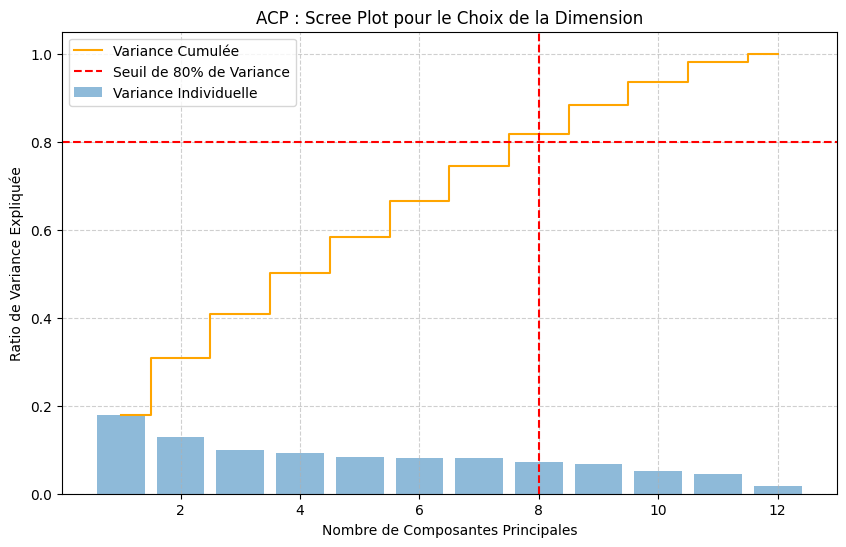

In [8]:
# Visualisation pour justifier le choix de N
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# Initialisation de la figure pour le graphique.

# Variance individuelle (Barres)
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Variance Individuelle')
# Trace les barres, chacune montrant la contribution d'une CP à la variance totale.

# Variance cumulée (Ligne)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Variance Cumulée', color='orange')
# Trace la ligne orange qui monte et montre la quantité d'information conservée en ajoutant des CP.

# Ligne de référence à 80%
plt.axhline(y=0.80, color='r', linestyle='--', label='Seuil de 80% de Variance')
# Ajoute la ligne horizontale pour le seuil de décision (80%).
plt.axvline(x=n_components_80, color='r', linestyle='--')
# Ajoute la ligne verticale pour marquer le nombre N choisi.

plt.xlabel('Nombre de Composantes Principales')
plt.ylabel('Ratio de Variance Expliquée')
plt.title('ACP : Scree Plot pour le Choix de la Dimension')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
# Affiche le graphique pour valider visuellement notre choix de N.

## 5. Analyse en Composantes Principales (ACP) 🔬: Transformation Finale
Maintenant que l'analyse de la variance de l'ACP est terminée et que le Scree Plot a confirmé notre choix (basé sur le seuil des $80\%$ de variance), nous avons déterminé le nombre optimal de Composantes Principales ($N$, que nous estimons être autour de 8). Il est temps de concrétiser la réduction de dimension.Jusqu'à présent, nous avons seulement ajusté notre modèle pca sur les données normalisées pour qu'il apprenne les axes de la variance. La prochaine étape est d'utiliser ce modèle pour transformer nos 12 features standardisées en ce nouvel espace réduit de $N$ dimensions.Nous allons créer un nouvel objet PCA spécifiquement pour $N$ composantes, puis nous appliquerons la méthode .transform() aux données. Cette action va projeter chaque morceau sur les $N$ axes les plus informatifs que l'ACP a identifiés. Le résultat sera un nouveau DataFrame. Si nous retenons $N=7$ composantes, ce DataFrame n'aura plus que 7 colonnes (nommées CP1 à CP7), représentant un vecteur de style simplifié et condensé pour chaque morceau. Ces 7 valeurs synthétisent l'information contenue dans les 12 features originales, ayant éliminé le bruit et la redondance. Ce DataFrame est l'entrée finale et idéale pour l'étape suivante : le Clustering K-Means.

Le code ci-dessous prend les données standardisées et les projette sur les 8 dimensions choisies :

In [9]:
# Nous fixons le nombre N=8 pour la transformation finale, en se basant sur la règle du seuil de 80%.
N_COMPONENTS = 8 

# 1. Création du modèle PCA final
pca_final = PCA(n_components=N_COMPONENTS)
# Nous créons une nouvelle instance de PCA, cette fois en spécifiant uniquement les 8 composantes à conserver.

# 2. Transformation des données
# Nous appliquons la transformation sur le DataFrame standardisé (X_scaled_df). 
# La méthode .fit_transform() effectue l'apprentissage final et la projection en une seule étape.
X_pca_final = pca_final.fit_transform(X_scaled_df)
# X_pca_final est maintenant un tableau NumPy de dimension (nombre_de_morceaux, 8).

# 3. Conversion du résultat en DataFrame pour le clustering
pca_cols = [f'CP{i+1}' for i in range(N_COMPONENTS)]
# Nous créons les noms de colonnes : CP1, CP2, ..., CP8.

X_pca_df = pd.DataFrame(X_pca_final, columns=pca_cols)
# Le résultat est stocké dans un DataFrame facile à manipuler.

print("\n--- Aperçu du Nouveau DataFrame Réduit (8 Dimensions) ---")
print(X_pca_df.head())

print("\n--- Dimensions du DataFrame final ---")
print(X_pca_df.shape)
# La forme du DataFrame doit être (nombre de morceaux, 8).

# Étape finale : Nous ajoutons les identifiants de morceau au DataFrame réduit 
# pour pouvoir lier les clusters aux morceaux originaux.
df_final_model = pd.concat([df[['track_id', 'track_artist', 'track_name']], X_pca_df], axis=1)
# Nous conservons l'ID, l'artiste et le nom, car ils sont essentiels pour le résultat final de la recommandation.


--- Aperçu du Nouveau DataFrame Réduit (8 Dimensions) ---
        CP1       CP2       CP3       CP4       CP5       CP6       CP7  \
0  1.540142  0.527212  0.794832 -0.467113 -0.821369 -0.721476 -0.400812   
1  1.090017  0.879849 -0.171874 -0.145500  0.558518 -0.139155 -1.458208   
2  1.638837  0.643873  0.350666  0.007159 -0.955531 -0.377351 -0.459231   
3  1.589418 -0.021349  0.307678  0.374661 -0.716976 -0.039261 -0.811501   
4  1.073438  0.338581  1.829808 -0.354135 -0.551872 -0.583170 -0.157899   

        CP8  
0  0.162239  
1  1.670500  
2 -0.662937  
3  0.020786  
4  0.230153  

--- Dimensions du DataFrame final ---
(32833, 8)


## 6. Clustering K-Means : Détermination du $K$ Optimal 
## 🧩6.1. Le Principe et le Défi du K-Means
Maintenant que nos morceaux sont représentés par des vecteurs de 8 dimensions ($\text{CP}_1$ à $\text{CP}_8$), notre objectif est de les regrouper pour créer des profils stylistiques homogènes. Nous utilisons l'algorithme de Clustering K-Means pour partitionner l'intégralité de notre dataset en $K$ groupes distincts. Chaque morceau sera assigné au centre de groupe, ou centroïde, le plus proche, garantissant que tous les morceaux d'un même cluster partagent des caractéristiques audio très similaires. Ces clusters nous serviront d'étiquettes de micro-genres pour filtrer les recommandations.Le principal défi de l'algorithme K-Means est qu'il est non supervisé et nécessite que nous lui fournissions le nombre de clusters ($K$) à l'avance. Un $K$ trop petit mènerait à des clusters trop vastes et hétérogènes (inutiles pour la recommandation), tandis qu'un $K$ trop grand mènerait à des groupes trop petits et redondants. Pour éviter de choisir un $K$ arbitrairement, nous devons trouver la valeur qui maximise l'homogénéité interne des clusters.6.2. La Méthode du Coude (Elbow Method)Pour déterminer ce $K$ idéal, nous employons la Méthode du Coude. Cette méthode repose sur le calcul de l'Inertie (également appelée WCSS, Within-Cluster Sum of Squares). L'inertie mesure la somme des carrés des distances entre chaque point (chaque morceau) et le centroïde de son propre cluster. Plus l'inertie est faible, plus les morceaux sont compacts et homogènes au sein de leurs groupes.Nous allons exécuter l'algorithme K-Means pour une plage de valeurs de $K$ (par exemple, de $K=1$ à $K=19$). Nous traçons ensuite la courbe de l'inertie en fonction du nombre de clusters $K$. Nous recherchons sur ce graphique le point où la courbe décroît fortement, puis commence à s'aplatir, formant un coude. C'est le point où l'ajout d'un cluster supplémentaire n'apporte plus un gain d'homogénéité suffisant pour justifier l'augmentation de la complexité du modèle.

## 6.3. Code de la Méthode du Coude

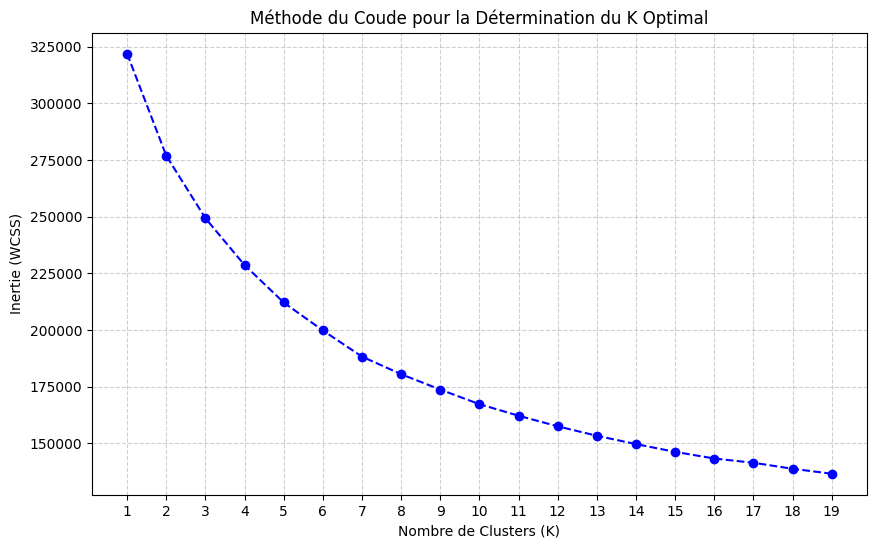

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Les colonnes des 8 Composantes Principales (CP1 à CP8)
# S'assurer que pca_cols est défini (ex: pca_cols = [f'CP{i+1}' for i in range(8)])
X_to_cluster = df_final_model[pca_cols]
# Nous isolons les 8 CP de notre DataFrame final pour le clustering.

# Initialisation d'une liste vide pour stocker les valeurs d'inertie
inertia = []
K_range = range(1, 20) 
# Nous définissons la plage de K à tester, de 1 cluster jusqu'à 19 clusters.

# Boucle pour tester K allant de 1 à 19
for k in K_range:
    # 1. Création du modèle K-Means pour la valeur k actuelle
    # n_init=10 assure que l'algorithme est exécuté 10 fois pour trouver un bon point de départ.
    # random_state=42 est utilisé pour garantir que les résultats sont reproductibles.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    # 2. Entraînement sur les données réduites (8 CP)
    kmeans.fit(X_to_cluster)
    
    # 3. Stockage de l'inertie calculée pour cette valeur de k
    inertia.append(kmeans.inertia_)
    # La propriété .inertia_ contient la somme des carrés des distances (WCSS) pour le modèle ajusté.

# 4. Affichage de la Courbe du Coude (Elbow Plot)
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--', color='blue')
# Tracé de la liste des inerties en fonction de la plage de K.

plt.title('Méthode du Coude pour la Détermination du K Optimal')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Inertie (WCSS)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(K_range)
plt.show()

# L'analyse visuelle du graphique qui suit l'exécution de ce code nous permettra de déterminer K.

L'analyse visuelle du graphique de la Méthode du Coude nous permet de déterminer le nombre optimal de clusters. La courbe représente la relation entre le nombre de clusters ($K$) et l'Inertie (ou WCSS).Nous observons une diminution très nette de l'Inertie pour les premières valeurs de $K$. Cependant, la courbe commence à s'adoucir et à s'aplatir à partir du point où $K$ est égal à 6. Ce point d'inflexion, qui forme le "coude", indique que l'ajout d'un cluster supplémentaire au-delà de 6 n'apporte plus une réduction significative de l'inertie, et donc n'augmente pas suffisamment la cohésion interne des groupes pour justifier la complexité accrue.Nous faisons donc le choix de retenir $K=6$ comme le nombre optimal de clusters. Notre modèle partitionnera le dataset en 6 profils stylistiques distincts, optimisant la similarité intra-cluster tout en conservant une complexité raisonnable.

## 7. Application Finale du Clustering K-Means ($K=6$) 

## 7.1. Lancement du Modèle
Après l'analyse de la Méthode du Coude, nous avons choisi $K=6$ comme étant le point d'équilibre entre la complexité et la cohésion des clusters. Nous appliquons maintenant l'algorithme K-Means une dernière fois à notre DataFrame réduit de 8 dimensions.Le but de cette exécution finale est simple : attribuer à chaque morceau une étiquette de cluster définitive, allant de 0 à 5. Chaque étiquette représente le groupe stylistique auquel le morceau est le plus proche mathématiquement.

In [11]:
from sklearn.cluster import KMeans

# La valeur K est fixée à 6 après l'analyse de la Méthode du Coude.
K_OPTIMAL = 6 

# Les colonnes des 8 Composantes Principales sont l'entrée.
X_to_cluster = df_final_model[pca_cols]

# 1. Création et entraînement du modèle K-Means final
# Nous utilisons la valeur K_OPTIMAL=6
kmeans = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init=10)
# Entraînement sur les 8 Composantes Principales 
kmeans.fit(X_to_cluster)

# 2. Assignation des clusters
# La méthode .labels_ retourne le numéro de cluster (0 à 5) pour chaque morceau.
cluster_labels = kmeans.labels_

# 3. Ajout des étiquettes de cluster au DataFrame final
# Ajout de la colonne 'Cluster_K6' au DataFrame principal du modèle.
df_final_model['Cluster_K6'] = cluster_labels

print("\n--- Aperçu du DataFrame final avec l'assignation des clusters ---")
# Affichage pour confirmer l'ajout de la colonne Cluster_K6.
print(df_final_model[['track_name', 'track_artist', 'CP1', 'CP2', 'Cluster_K6']].head())

print(f"\nLe Clustering K-Means a assigné les {len(df_final_model)} morceaux à 6 groupes (clusters 0 à 5).")


--- Aperçu du DataFrame final avec l'assignation des clusters ---
                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        Ed Sheeran   
1                    Memories - Dillon Francis Remix          Maroon 5   
2                    All the Time - Don Diablo Remix      Zara Larsson   
3                  Call You Mine - Keanu Silva Remix  The Chainsmokers   
4            Someone You Loved - Future Humans Remix     Lewis Capaldi   

        CP1       CP2  Cluster_K6  
0  1.540142  0.527212           1  
1  1.090017  0.879849           1  
2  1.638837  0.643873           5  
3  1.589418 -0.021349           5  
4  1.073438  0.338581           1  

Le Clustering K-Means a assigné les 32833 morceaux à 6 groupes (clusters 0 à 5).


## 8. Interprétation des Clusters 

## 8.1. L'Importance de l'Interprétation
À ce stade, nous avons un DataFrame parfaitement structuré, mais la colonne Cluster_K6 n'a aucune signification métier : le Cluster 0 ou le Cluster 4 ne nous dit rien sur le style musical qu'il contient.

L'étape suivante est donc l'Interprétation. Nous devons analyser les caractéristiques moyennes de chaque cluster pour pouvoir leur donner un nom compréhensible (par exemple, Cluster 0 devient "Pop Énergique et Dansante").

## 8.2. Le Processus d'Interprétation
Pour donner un nom à chaque cluster, nous allons effectuer une analyse descriptive :

Calcul des Moyennes : Nous regrouperons le DataFrame par la nouvelle colonne Cluster_K6 et calculerons la moyenne des 8 Composantes Principales pour chaque groupe.

Analyse des Centroids : Nous examinerons les centroïdes (les centres des clusters) et les comparerons au reste des données pour voir quelles features (CP) sont significativement au-dessus ou au-dessous de la moyenne générale (0).

Renommage : En se basant sur cette analyse, nous donnerons des noms clairs à nos 6 clusters. Ce renommage est crucial pour la lisibilité et pour le développement futur des règles métier dans l'application (ex : "Si l'utilisateur aime le cluster 'Électronique Sombre', recommander 80% de ce cluster").

8.3. Code d'Analyse des Centroids

In [12]:
# Nous analysons les centres des clusters (centroids)
cluster_centroids = pd.DataFrame(kmeans.cluster_centers_, columns=pca_cols)

# Nous regroupons ensuite le DataFrame principal pour calculer les moyennes des CP par cluster
# Cette table est essentielle pour déterminer la "personnalité" de chaque groupe
cluster_summary = df_final_model.groupby('Cluster_K6')[pca_cols].mean()

print("\n--- Analyse des Centres de Clusters (Moyennes des 8 CP par Cluster) ---")
print(cluster_summary)

# Le tableau ci-dessus est la clé pour le renommage : 
# Un cluster avec une forte moyenne positive sur CP1 ("Intensité Globale") 
# et une forte moyenne négative sur CP3 ("Acoustique") sera nommé en conséquence.


--- Analyse des Centres de Clusters (Moyennes des 8 CP par Cluster) ---
                 CP1       CP2       CP3       CP4       CP5       CP6  \
Cluster_K6                                                               
0          -2.536941 -0.501727  0.075845  0.215822  0.071207 -0.291299   
1           0.263048  0.849930  0.233369 -0.564360  0.100961 -0.325817   
2           0.233238 -1.415980 -0.612449 -1.530207 -1.206916  1.702447   
3           1.023297 -0.471275 -0.325296  0.998114  1.608833  1.159742   
4          -0.212038  1.205199 -0.336420  0.964365 -0.131030  0.546744   
5           0.865414 -0.877837  0.114877  0.246034 -0.196188 -0.546433   

                 CP7       CP8  
Cluster_K6                      
0          -0.240400  0.117460  
1          -0.165149  0.199384  
2           0.400360  0.522997  
3          -0.679995  0.631163  
4           0.855598 -0.672991  
5          -0.036973 -0.293117  


In [13]:
# Définition du dictionnaire de renommage final
cluster_names = {
    0: 'Musique Calme & Instrumentale', 
    1: 'Hip-Hop / Électro Rythmé', 
    2: 'Danse / Électronique Mélancolique', 
    3: 'Rock / Pop Standard', 
    4: 'Musique Triste / Indépendante', 
    5: 'Pop Radio / Joyeuse & Dansante'
}

# 1. Ajout de la colonne descriptive
df_final_model['Cluster_Style'] = df_final_model['Cluster_K6'].map(cluster_names)

# 2. Suppression de l'ancienne colonne numérique
df_final_model = df_final_model.drop(columns=['Cluster_K6'])

print("\n--- Aperçu du DataFrame Final avec Noms de Clusters Corrigés ---")
print(df_final_model[['track_name', 'track_artist', 'Cluster_Style']].head())


--- Aperçu du DataFrame Final avec Noms de Clusters Corrigés ---
                                          track_name      track_artist  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...        Ed Sheeran   
1                    Memories - Dillon Francis Remix          Maroon 5   
2                    All the Time - Don Diablo Remix      Zara Larsson   
3                  Call You Mine - Keanu Silva Remix  The Chainsmokers   
4            Someone You Loved - Future Humans Remix     Lewis Capaldi   

                    Cluster_Style  
0        Hip-Hop / Électro Rythmé  
1        Hip-Hop / Électro Rythmé  
2  Pop Radio / Joyeuse & Dansante  
3  Pop Radio / Joyeuse & Dansante  
4        Hip-Hop / Électro Rythmé  


Cette commande filtre le DataFrame pour ne conserver que les morceaux d'un style, puis en sélectionne 5 aléatoirement.

In [14]:
# Définir le nom du cluster corrigé que vous souhaitez vérifier
CLUSTER_A_VERIFIER = 'Pop Radio / Joyeuse & Dansante' 

# Récupération de 5 morceaux aléatoires du cluster
morceaux_validation = df_final_model[
    df_final_model['Cluster_Style'] == CLUSTER_A_VERIFIER
].sample(5, random_state=42) # 'sample(5)' choisit 5 lignes au hasard

print(f"\n--- 5 Morceaux Aléatoires du Cluster : {CLUSTER_A_VERIFIER} ---")
print(morceaux_validation[['track_name', 'track_artist', 'Cluster_Style']])


--- 5 Morceaux Aléatoires du Cluster : Pop Radio / Joyeuse & Dansante ---
        track_name         track_artist                   Cluster_Style
25685    Eagle Eye            Ava Raiin  Pop Radio / Joyeuse & Dansante
5039   From Finner  Of Monsters and Men  Pop Radio / Joyeuse & Dansante
4358           85%                Loote  Pop Radio / Joyeuse & Dansante
10832   Love Scars         Trippie Redd  Pop Radio / Joyeuse & Dansante
27610  Butterflies                 Myon  Pop Radio / Joyeuse & Dansante


## Exportation

In [15]:
# CODE D'EXPORTATION FINAL
# Assurez-vous d'utiliser un nom de fichier clair et de ne pas inclure l'index Pandas.
df_final_model.to_csv('spotify_data_preprocessed_final.csv', index=False)
print("\n--- Exportation réussie ! ---")
print("Le fichier 'spotify_data_preprocessed_final.csv' est prêt pour l'intégration SQLite.")


--- Exportation réussie ! ---
Le fichier 'spotify_data_preprocessed_final.csv' est prêt pour l'intégration SQLite.


## Visualisation

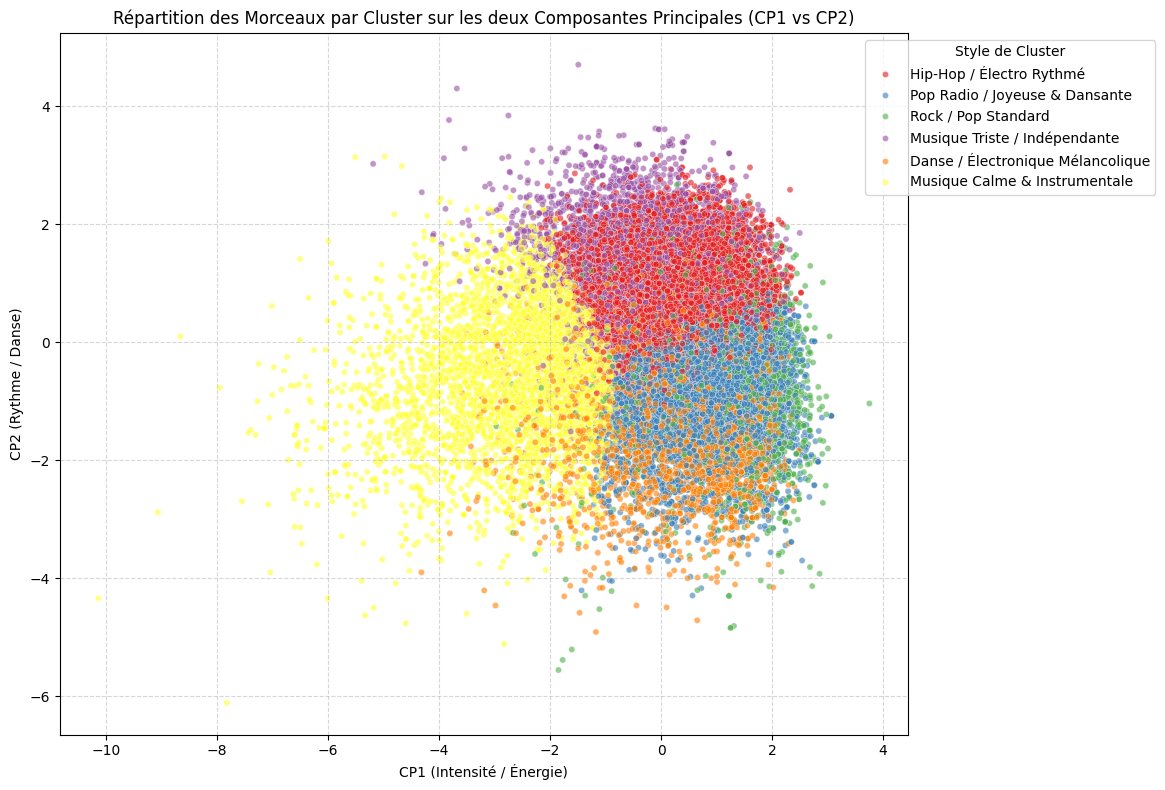

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des deux premières CP pour la visualisation 2D
X_plot = df_final_model[['CP1', 'CP2']]
cluster_styles = df_final_model['Cluster_Style']

# Initialisation de la figure
plt.figure(figsize=(12, 8))

# Création du nuage de points avec coloration par cluster
# Nous utilisons seaborn pour une meilleure gestion des couleurs et des légendes.
sns.scatterplot(
    x=X_plot['CP1'], 
    y=X_plot['CP2'], 
    hue=cluster_styles,  # Couleur basée sur le nom du cluster
    palette='Set1',      # Choix d'une palette de couleurs distincte
    s=20,                # Taille des points
    alpha=0.6            # Transparence pour voir la densité
)

# Ajout des titres et légendes
plt.title('Répartition des Morceaux par Cluster sur les deux Composantes Principales (CP1 vs CP2)')
plt.xlabel('CP1 (Intensité / Énergie)')
plt.ylabel('CP2 (Rythme / Danse)')
plt.legend(title='Style de Cluster', loc='upper right', bbox_to_anchor=(1.3, 1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout() # Ajuste la figure pour qu'elle soit bien visible
plt.show()

## Prochaine etape : creation de la bdd puis importation
J'ai cree le schema (bdd.sql) et avec le script tqt.py j'ai crée puis rempli la bdd dans mon projet flutter, ensuite j'ai commencé l'integration de la bdd et la creation des requetes sql pour le systeme de recommandation.

## Logique de recommandation 
Démarrage à Froid (Cold Start) : Si l'utilisateur n'a fait aucun swipe (liked = 0 pour tous les morceaux), proposer des morceaux populaires.

Calcul du Profil Vectoriel : Calculer la moyenne des 8 CP à partir des swipes (liked = 1 et liked = -1).

Recommandation Vectorielle (70%) : Trouver les 7 morceaux non vus les plus proches du profil vectoriel (via Distance Euclidienne).

Recommandation Artiste (30%) : Trouver 3 morceaux non vus d'artistes que l'utilisateur a aimés (liked = 1).

Filtrage Découverte : Mélanger 80% de morceaux populaires (track_popularity > 50) et 20% de découverte (track_popularity <= 50) sur l'ensemble.